<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Scatter map with data mode of one BGC variable

This notebook shows how to:
- download BGC-Argo index
- search for profiles with a specific parameter
- export search results as a Pandas DataFrame
- extract data mode values for this parameter
- download info from Argo NVS Reference Tables about a parameter
- plot a map where profile locations are color coded with parameter data mode

In [1]:
from argopy import ArgoIndex  #  This is the class to work with Argo index content
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy.plot import scatter_map  # This is a function to easily make maps 

import numpy as np
from matplotlib import pyplot as plt

In [14]:
# Load an index of BGC profiles:
# idx = ArgoIndex(index_file='bgc-s').load()  # 'bgc-s' is a shortcut for 'argo_synthetic-profile_index.txt'
idx = ArgoIndex(index_file='bgc-b').load()  # 'bgc-b' is a shortcut for 'argo_bio-profile_index.txt'
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_bio-profile_index.txt.gz
Convention: argo_bio-profile_index (Bio-Profile directory file of the Argo GDAC)
In memory: True (379298 records)
Searched: False

In [15]:
# Define a parameter to work with:
# param = 'BBP470'
# param = 'DOXY'
param = 'BBP700'

In [16]:
# Get more verbose information about this parameter (usefull for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==param].iloc[0]
param_info

altLabel                                                 BBP700
prefLabel             Particle backscattering at 700 nanometers
definition    Particle backscattering at 700 nm wavelength, ...
deprecated                                                false
id            http://vocab.nerc.ac.uk/collection/R03/current...
Name: 44, dtype: object

In [17]:
# Search for this parameter profiles:
idx.query.params(param)
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_bio-profile_index.txt.gz
Convention: argo_bio-profile_index (Bio-Profile directory file of the Argo GDAC)
In memory: True (379298 records)
Searched: True (172805 matches, 45.5592%) - {'PARAMS': (['BBP700'], 'and')}

In [18]:
# Possibly add a search in time (just to make a map more readable):
# idx.query.date([-180,180,-90,90,'2023-01','2023-07'])
# idx

In [19]:
# Export search results to a dataframe:
df = idx.to_dataframe()
df.sample(5)

/var/folders/ww/psmkfjds7xsc4kjsz66ghldr000nsn/T/ipykernel_54074/341042361.py:2: FutureWarning: Note that the long name for institution is now in 'institution_name' while the 'institution' column will hold the institution code -- Deprecated since version 1.4
  df = idx.to_dataframe()


,file,date,latitude,longitude,ocean,profiler_code,institution,parameters,parameter_data_mode,date_update,wmo,cyc,institution_name,dac,profiler
1995,aoml/1902458/profiles/BD1902458_027.nc,2024-02-29 02:55:11,13.463,67.033,I,863,AO,PRES TEMP_DOXY PHASE_DELAY_DOXY TEMP_VOLTAGE_D...,RRRRARAARARRRRRDRRD,2025-12-21 12:17:24,1902458,27,"AOML, USA",aoml,Navis-A float with SBE conductivity sensor
118243,coriolis/6903197/profiles/BD6903197_055.nc,2016-09-12 10:37:00,42.328,17.764,A,836,IF,PRES C1PHASE_DOXY C2PHASE_DOXY TEMP_DOXY C1PHA...,RRRRRRRRRRDRRRRRRRRRRRRDDDDRRRRRRRRRAADRRRRRRRRA,2023-09-15 12:23:52,6903197,55,"Ifremer, France",coriolis,PROVOR III
91238,coriolis/6901516/profiles/BD6901516_028.nc,2013-05-15 12:36:00,62.251,-21.645,A,836,IF,PRES RAW_DOWNWELLING_IRRADIANCE380 RAW_DOWNWEL...,RRRRRRRRRRRRRDDDDRRRRRRRRRAADR,2023-09-13 15:43:09,6901516,28,"Ifremer, France",coriolis,PROVOR III
142331,csiro/5903679/profiles/BD5903679_058.nc,2011-07-08 04:04:27,-47.844,145.030,P,846,CS,PRES DOXY FREQUENCY_DOXY CHLA FLUORESCENCE_CHL...,RDRARRRR,2023-09-18 11:34:34,5903679,58,"CSIRO, Australia",csiro,Teledyne Webb Research float with SBE conducti...
162748,incois/2902276/profiles/BD2902276_011.nc,2019-08-22 22:24:10,20.302,66.985,I,846,IN,PRES DOXY TPHASE_DOXY CHLA FLUORESCENCE_CHLA B...,RDRARRRR,2024-12-23 15:29:15,2902276,11,"INCOIS, India",incois,Teledyne Webb Research float with SBE conducti...


In [20]:
# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(param)] if param in x['variables'] else '', axis=1)

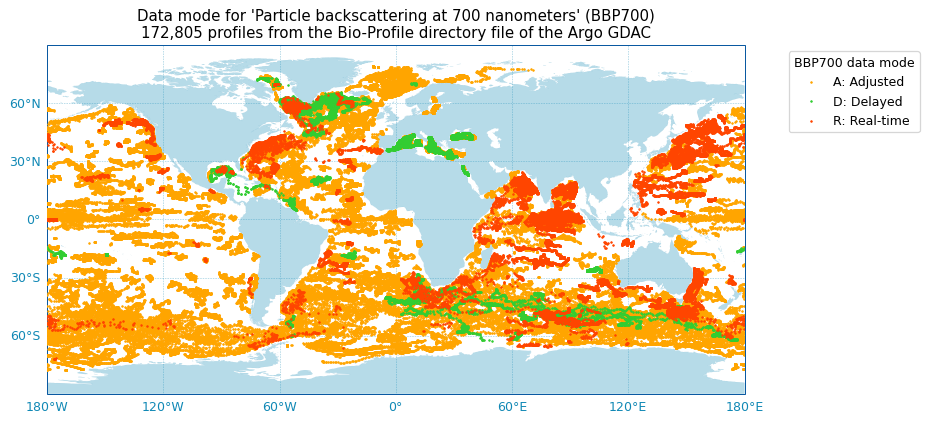

In [22]:
# Finally plot the map:
fig, ax, _ = scatter_map(df,
                        hue="%s_DM" % param,
                        cmap="data_mode",
                        figsize=(10,6),
                        markersize=2,
                        markeredgecolor=None,
                        traj=False,  # Because some floats do weird things around 180/-180
                        set_global=True,
                        legend_title='%s data mode' % param)
ax.set_title("Data mode for '%s' (%s)\n%s profiles from the %s" % (param_info['prefLabel'], 
                                                                   param, 
                                                                   "{:,}".format(idx.N_MATCH), 
                                                                   idx.convention_title)
            );